In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# # Interactive plots
# %matplotlib notebook

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage

TensorFlow version is 2.1.0


Using TensorFlow backend.


In [80]:
# # Load the real dataset
# X, Y, info = mypackage.Dataset.load("data/tomra", only_with_contaminant=True)
# X_train, X_test, Y_train, Y_test = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

# X_test, X_train = mypackage.Dataset.scale(X_test, X_train, scale='GlobalStandardization')
# # X_test, X_train = mypackage.Dataset.PCA(X_test, X_train, n_components=3, plot=True, whiten=True)

# print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape)

### The fake dataset is by default a absorbance dataset. In order to use it as a pre-taining dataset for the TOMRA dataset, then either one of them need to converterd to absorbance or reflectance like the other.

In [146]:
# Setting the wavelengths to be the same as the real dataset collected at TOMRA
wavelengths = mypackage.Dataset.TOMRA_WAVELENGTHS

# The fake dataset is by default a absorbance dataset
fake_data = mypackage.FakeDataset(wavelengths=wavelengths)
X, Y = fake_data.get_images(50)

In [147]:
X_train, X_test, Y_train, Y_test = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

X_test, X_train = mypackage.Dataset.scale(X_test, X_train, scale='GlobalStandardization')
# X_test, X_train = mypackage.Dataset.PCA(X_test, X_train, n_components=3, plot=True, whiten=True)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape)

[1 2] (15, 64, 64, 1) (-10.680117367209634, 1.6511396941425442) (15, 64, 64, 208)


In [148]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(value=y_true, dtype=tf.float32)
        y_pred = tf.convert_to_tensor(value=y_pred, dtype=tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(input_tensor=fl, axis=1)
        return tf.reduce_mean(input_tensor=reduced_fl)
    return focal_loss_fixed

In [150]:
import tensorflow_addons as tfa
import tensorflow as tf
# fl = tfa.losses.SigmoidFocalCrossEntropy()
fl = focal_loss(alpha=1)

unet = mypackage.MyUnet.UNet(X_train, Y_train, loss_func=fl)
unet.train(batch_size=5, epochs=30, validation_split=0.1)
# unet.summary()

Train on 31 samples, validate on 4 samples
Epoch 1/30
31/31 [==============================] - 7s 212ms/step - loss: 0.4866 - accuracy: 0.6532 - val_loss: 0.1337 - val_accuracy: 0.5925

Epoch 00001: accuracy improved from -inf to 0.65319, saving model to best-model.hdf5
Epoch 2/30
31/31 [==============================] - 5s 171ms/step - loss: 0.2309 - accuracy: 0.6276 - val_loss: 0.1250 - val_accuracy: 0.6041

Epoch 00002: accuracy did not improve from 0.65319
Epoch 3/30
31/31 [==============================] - 5s 172ms/step - loss: 0.1648 - accuracy: 0.6290 - val_loss: 0.0974 - val_accuracy: 0.5999

Epoch 00003: accuracy did not improve from 0.65319
Epoch 4/30
31/31 [==============================] - 5s 174ms/step - loss: 0.1321 - accuracy: 0.6524 - val_loss: 0.0789 - val_accuracy: 0.5860

Epoch 00004: accuracy did not improve from 0.65319
Epoch 5/30
31/31 [==============================] - 5s 172ms/step - loss: 0.1125 - accuracy: 0.6975 - val_loss: 0.0746 - val_accuracy: 0.5545

Epoc

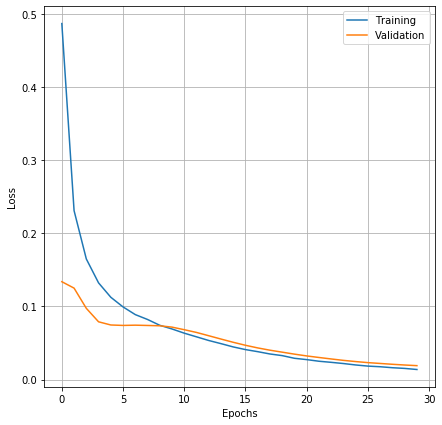

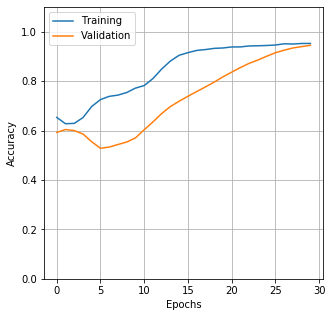

In [151]:
unet.plot_training_results()

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    139145
           1       0.36      0.57      0.44      4215

    accuracy                           0.96    143360
   macro avg       0.67      0.77      0.71    143360
weighted avg       0.97      0.96      0.96    143360



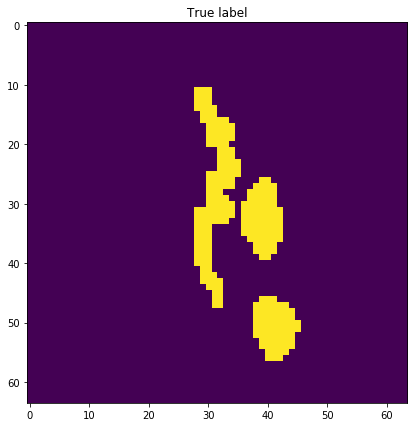

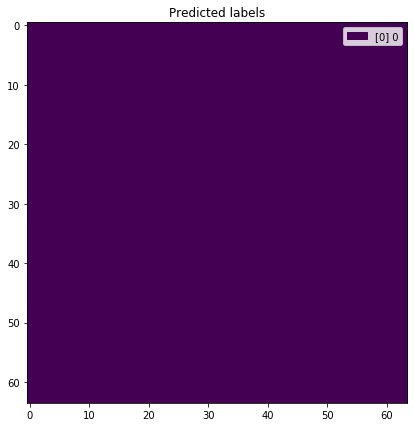

In [153]:
unet.predict(X_train, Y_labels=Y_train)

Train on 31 samples, validate on 4 samples
Epoch 1/30
31/31 [==============================] - 7s 219ms/step - loss: 0.6877 - accuracy: 0.5554 - val_loss: 0.7070 - val_accuracy: 0.4739

Epoch 00001: accuracy improved from -inf to 0.55542, saving model to best-model.hdf5
Epoch 2/30
31/31 [==============================] - 5s 169ms/step - loss: 0.6202 - accuracy: 0.7864 - val_loss: 0.7749 - val_accuracy: 0.3239

Epoch 00002: accuracy improved from 0.55542 to 0.78636, saving model to best-model.hdf5
Epoch 3/30
31/31 [==============================] - 5s 167ms/step - loss: 0.5746 - accuracy: 0.8837 - val_loss: 0.7922 - val_accuracy: 0.2380

Epoch 00003: accuracy improved from 0.78636 to 0.88374, saving model to best-model.hdf5
Epoch 4/30
31/31 [==============================] - 5s 166ms/step - loss: 0.5447 - accuracy: 0.9047 - val_loss: 0.7574 - val_accuracy: 0.2261

Epoch 00004: accuracy improved from 0.88374 to 0.90474, saving model to best-model.hdf5
Epoch 5/30
31/31 [==================

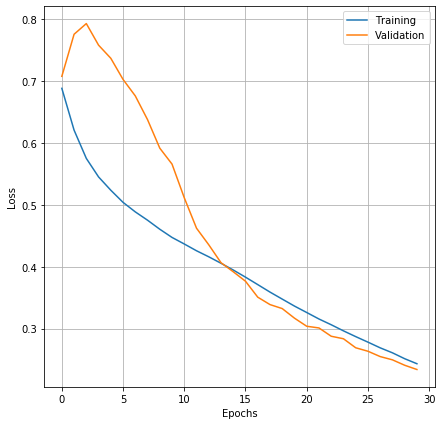

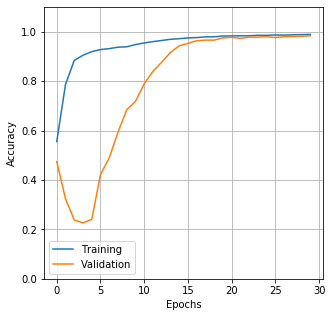

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    139145
           1       0.84      0.83      0.83      4215

    accuracy                           0.99    143360
   macro avg       0.92      0.91      0.91    143360
weighted avg       0.99      0.99      0.99    143360



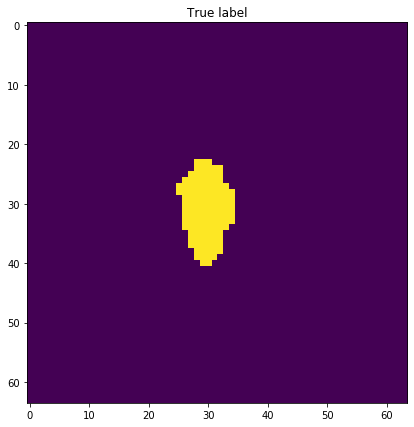

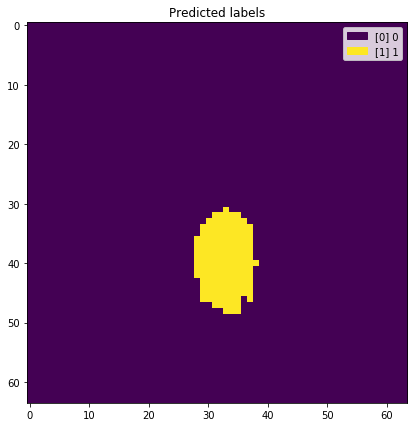

In [155]:
unet = mypackage.MyUnet.UNet(X_train, Y_train)
unet.train(batch_size=5, epochs=30, validation_split=0.1)
unet.plot_training_results()
unet.predict(X_train, Y_labels=Y_train)

In [107]:
# Load the real dataset
# dataset_folder = "data/tomra"
# obvious_plastics = ["20200213_120044_FM_fillet_repeat_sample_B_32", "20200213_120111_FM_fillet_repeat_sample_B_33", "20200213_120158_FM_fillet_repeat_sample_B_34", "20200213_120308_FM_fillet_repeat_sample_B_36", "20200213_120339_FM_fillet_repeat_sample_B_37", "20200213_120359_FM_fillet_repeat_sample_B_38"]
# X, Y, info = mypackage.Dataset.load_files(obvious_plastics, dataset_folder, only_one_contaminant_type=True)
X, Y, info = mypackage.Dataset.load("data/tomra", only_with_contaminant=True)

enlarged_X, enlarged_Y = mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=32, sample_multiplication=7, contaminant_type=3)

X_train, X_test, Y_train, Y_test = mypackage.Dataset.train_test_split(enlarged_X, enlarged_Y, testRatio=0.3)

# X_test, X_train, _ = mypackage.Dataset.scale(X_test, X_train, scaler='GlobalStandardization')
# # X_test, X_train = mypackage.Dataset.PCA(X_test, X_train, n_components=3, plot=True, whiten=True)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)

[1. 2. 3.] (51, 32, 32, 1) (1.5502803325653076, 73.80110931396484) (51, 32, 32, 208) (117, 32, 32, 208)


<IPython.core.display.Javascript object>


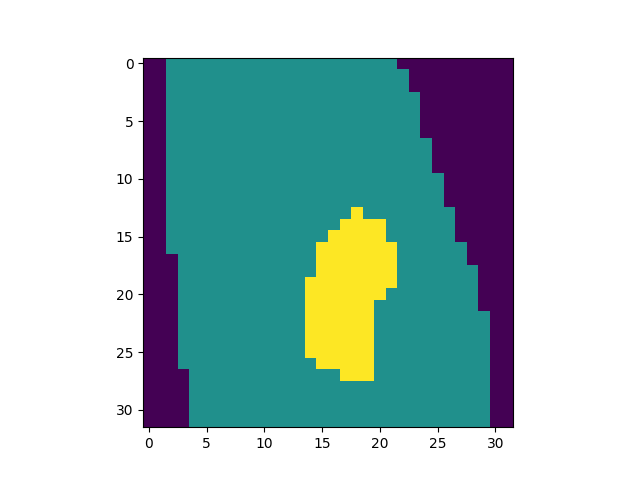

50


In [41]:
# for i in range(10):
# choice = np.random.choice(len(enlarged_Y))
plt.figure()
print(choice)
plt.imshow(np.squeeze(enlarged_Y[choice]))

<IPython.core.display.Javascript object>


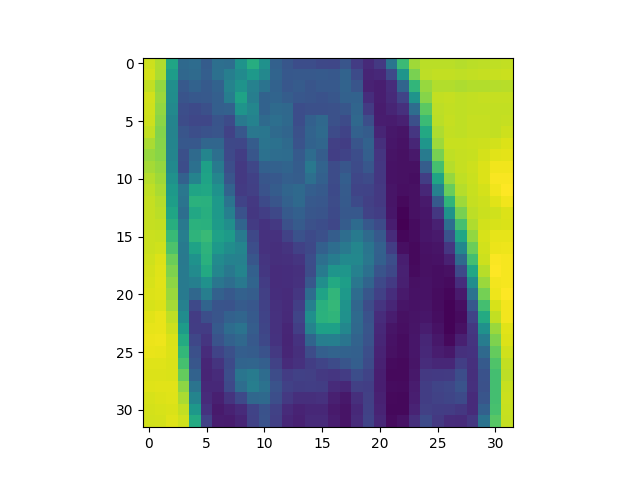

50
(32, 32)


In [49]:
plt.figure()
print(choice)
# plt.imshow(enlarged_X[choice, :, :, 140])
a = enlarged_X[choice]
plt.imshow(np.average(a, axis=-1))
print(np.average(a, axis=-1).shape)

c4: (None, 4, 4, 64)
Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           (None, 32, 32, 208,  0                                            
__________________________________________________________________________________________________
conv3d_167 (Conv3D)             (None, 32, 32, 70, 8 512         input_60[0][0]                   
__________________________________________________________________________________________________
batch_normalization_637 (BatchN (None, 32, 32, 70, 8 32          conv3d_167[0][0]                 
__________________________________________________________________________________________________
conv3d_168 (Conv3D)             (None, 16, 16, 24, 1 5776        batch_normalization_637[0][0]    
______________________________________________________________________

Train on 105 samples, validate on 12 samples
Epoch 1/30
105/105 [==============================] - 8s 72ms/step - loss: 0.9154 - accuracy: 0.6602 - val_loss: 1.1230 - val_accuracy: 0.2840

Epoch 00001: accuracy improved from -inf to 0.66024, saving model to best-model.hdf5
Epoch 2/30
105/105 [==============================] - 6s 53ms/step - loss: 0.8127 - accuracy: 0.7239 - val_loss: 1.0734 - val_accuracy: 0.5889

Epoch 00002: accuracy improved from 0.66024 to 0.72391, saving model to best-model.hdf5
Epoch 3/30
105/105 [==============================] - 6s 56ms/step - loss: 0.7476 - accuracy: 0.7727 - val_loss: 1.0593 - val_accuracy: 0.5940

Epoch 00003: accuracy improved from 0.72391 to 0.77273, saving model to best-model.hdf5
Epoch 4/30
105/105 [==============================] - 6s 56ms/step - loss: 0.6924 - accuracy: 0.7923 - val_loss: 0.9377 - val_accuracy: 0.7398

Epoch 00004: accuracy improved from 0.77273 to 0.79232, saving model to best-model.hdf5
Epoch 5/30
105/105 [==========

<IPython.core.display.Javascript object>


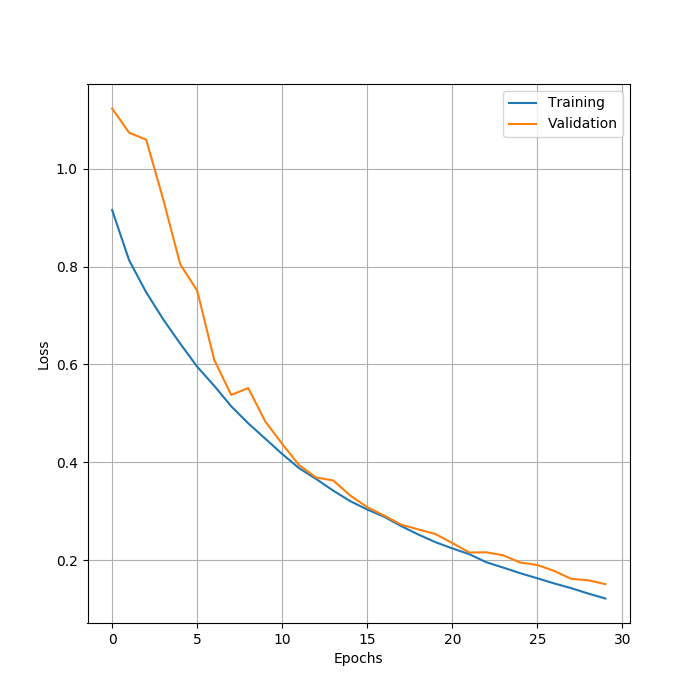

<IPython.core.display.Javascript object>


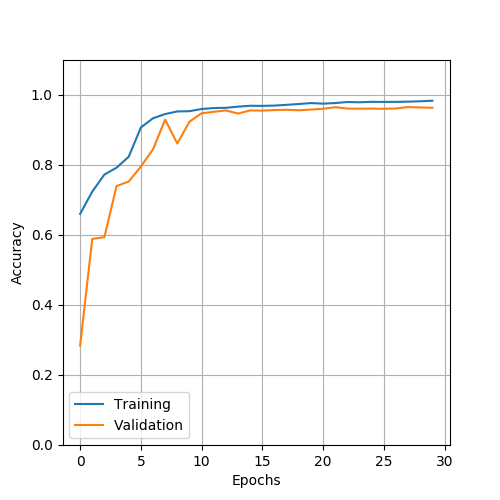

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      9430
           1       0.97      0.98      0.97     37333
           2       0.90      0.90      0.90      5461

    accuracy                           0.96     52224
   macro avg       0.94      0.94      0.94     52224
weighted avg       0.96      0.96      0.96     52224



<IPython.core.display.Javascript object>


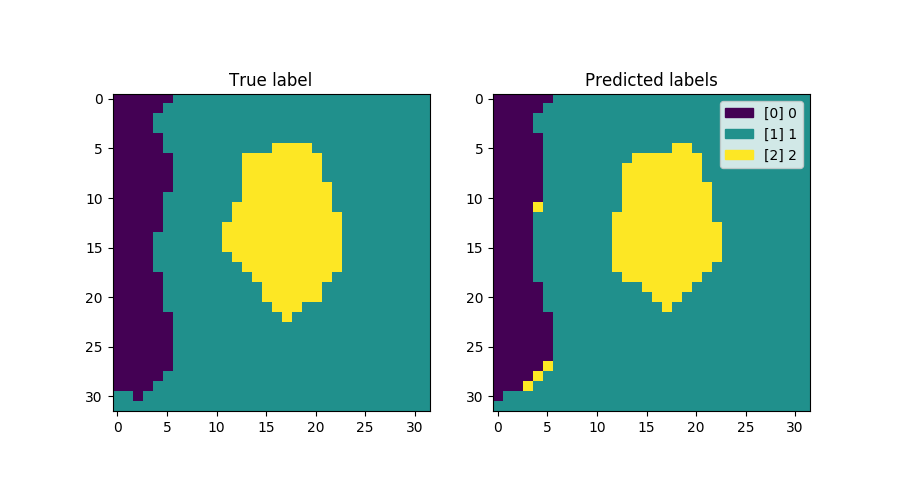

In [110]:
unet = mypackage.MyUnet.UNet(X_train, Y_train)
unet.summary()
unet.train(batch_size=5, epochs=30, validation_split=0.1)
unet.plot_training_results()
unet.predict(X_test, Y_labels=Y_test)

c4: (None, 4, 4, 64)
Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           (None, 32, 32, 208,  0                                            
__________________________________________________________________________________________________
conv3d_164 (Conv3D)             (None, 32, 32, 70, 8 512         input_59[0][0]                   
__________________________________________________________________________________________________
conv3d_165 (Conv3D)             (None, 16, 16, 24, 1 5776        conv3d_164[0][0]                 
__________________________________________________________________________________________________
conv3d_166 (Conv3D)             (None, 8, 8, 8, 32)  13856       conv3d_165[0][0]                 
______________________________________________________________________

Train on 105 samples, validate on 12 samples
Epoch 1/30
105/105 [==============================] - 6s 60ms/step - loss: 1.3043 - accuracy: 0.1416 - val_loss: 1.9482 - val_accuracy: 0.1010

Epoch 00001: accuracy improved from -inf to 0.14156, saving model to best-model.hdf5
Epoch 2/30
105/105 [==============================] - 5s 48ms/step - loss: 1.0678 - accuracy: 0.2903 - val_loss: 1.0486 - val_accuracy: 0.4109

Epoch 00002: accuracy improved from 0.14156 to 0.29030, saving model to best-model.hdf5
Epoch 3/30
105/105 [==============================] - 5s 46ms/step - loss: 0.9108 - accuracy: 0.7373 - val_loss: 0.9158 - val_accuracy: 0.7004

Epoch 00003: accuracy improved from 0.29030 to 0.73729, saving model to best-model.hdf5
Epoch 4/30
105/105 [==============================] - 5s 46ms/step - loss: 0.8502 - accuracy: 0.8764 - val_loss: 0.8257 - val_accuracy: 0.8352

Epoch 00004: accuracy improved from 0.73729 to 0.87640, saving model to best-model.hdf5
Epoch 5/30
105/105 [==========

<IPython.core.display.Javascript object>


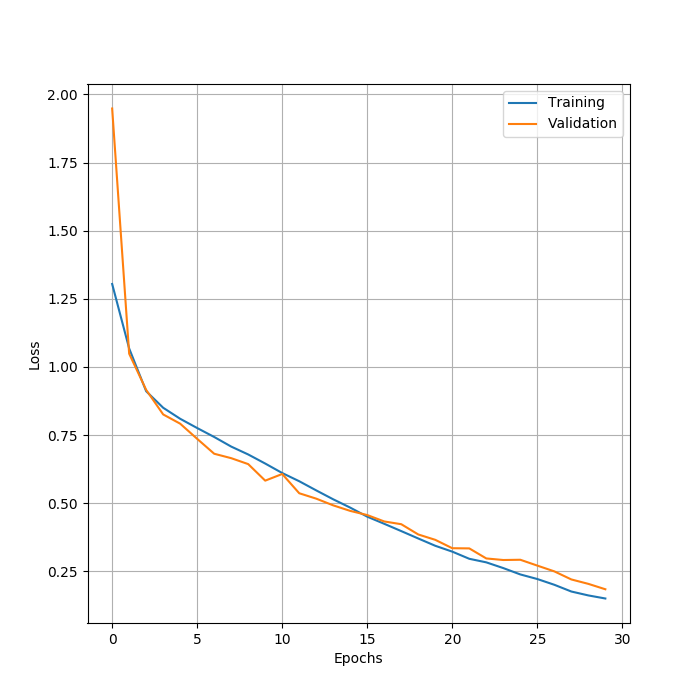

<IPython.core.display.Javascript object>


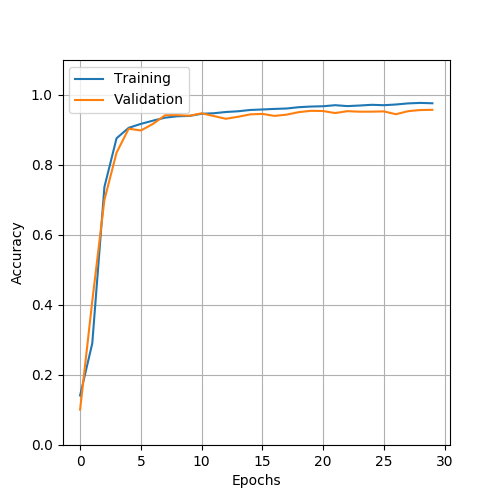

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     24632
           1       0.98      0.99      0.99     82394
           2       0.96      0.92      0.94     12782

    accuracy                           0.98    119808
   macro avg       0.97      0.97      0.97    119808
weighted avg       0.98      0.98      0.98    119808



<IPython.core.display.Javascript object>


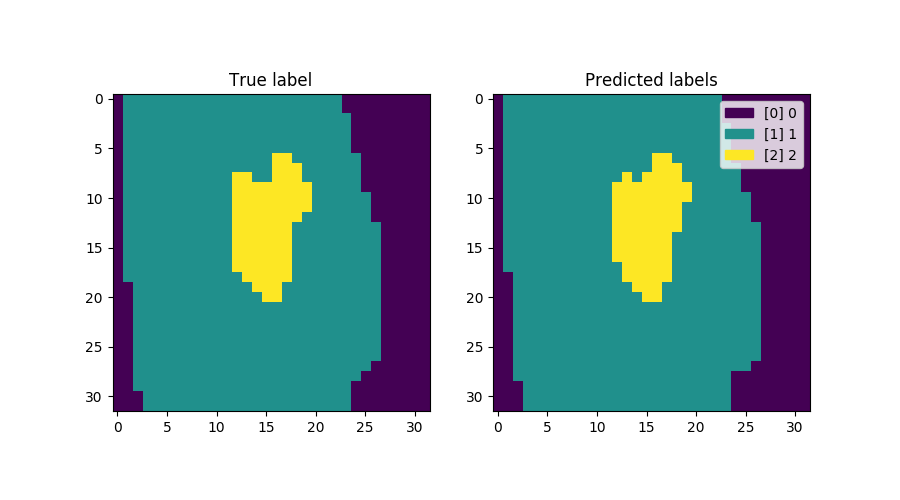

In [108]:
unet = mypackage.MyUnet.UNet(X_train, Y_train)
unet.summary()
unet.train(batch_size=5, epochs=30, validation_split=0.1)
unet.plot_training_results()
unet.predict(X_test, Y_labels=Y_test)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      9430
           1       0.97      0.97      0.97     37333
           2       0.91      0.83      0.86      5461

    accuracy                           0.96     52224
   macro avg       0.94      0.92      0.93     52224
weighted avg       0.96      0.96      0.96     52224



<IPython.core.display.Javascript object>


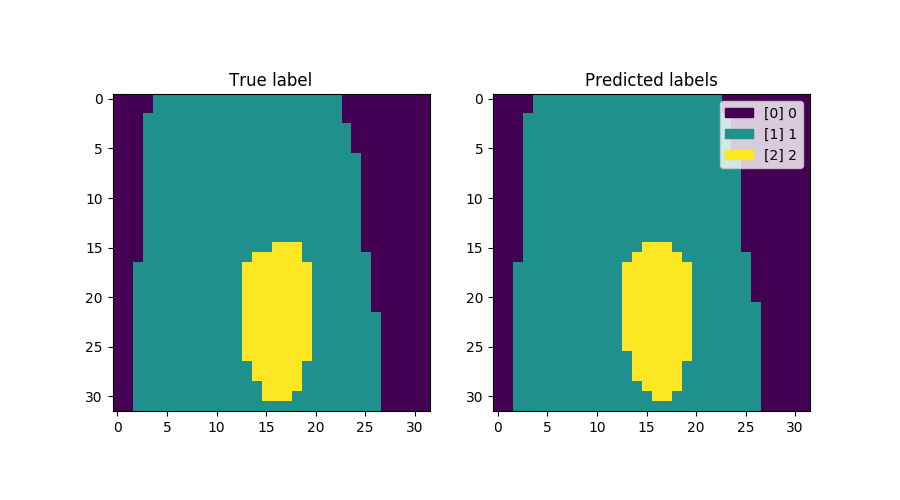

In [109]:
unet.predict(X_test, Y_labels=Y_test)

In [10]:
unet.retrain(X_train, Y_train, freeze_up_to=0, batch_size=20, epochs=30, validation_split=0.1)
# unet.plot_training_results()

Number of layers in the base model:  34
Train on 3 samples, validate on 1 samples
Epoch 1/30
3/3 [==============================] - 2s 586ms/step - loss: 0.3354 - accuracy: 0.9089 - val_loss: 0.3333 - val_accuracy: 0.8770
Epoch 2/30
3/3 [==============================] - 1s 181ms/step - loss: 0.3215 - accuracy: 0.9054 - val_loss: 0.3578 - val_accuracy: 0.8494
Epoch 3/30
3/3 [==============================] - 1s 181ms/step - loss: 0.3106 - accuracy: 0.9111 - val_loss: 0.3746 - val_accuracy: 0.8325
Epoch 4/30
3/3 [==============================] - 1s 188ms/step - loss: 0.2992 - accuracy: 0.9218 - val_loss: 0.3765 - val_accuracy: 0.8188
Epoch 5/30
3/3 [==============================] - 1s 181ms/step - loss: 0.2904 - accuracy: 0.9276 - val_loss: 0.3629 - val_accuracy: 0.8174
Epoch 6/30
3/3 [==============================] - 1s 177ms/step - loss: 0.2869 - accuracy: 0.9310 - val_loss: 0.3454 - val_accuracy: 0.8247
Epoch 7/30
3/3 [==============================] - 1s 180ms/step - loss: 0.2825

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7893
           1       0.02      0.02      0.02       299

    accuracy                           0.92      8192
   macro avg       0.49      0.49      0.49      8192
weighted avg       0.93      0.92      0.93      8192



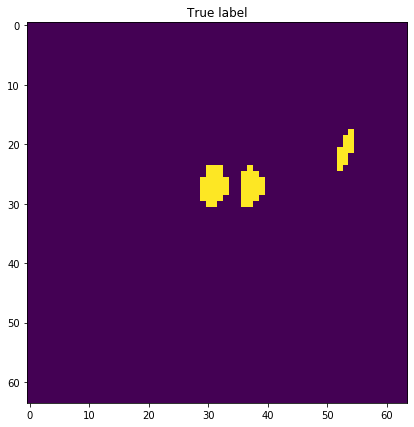

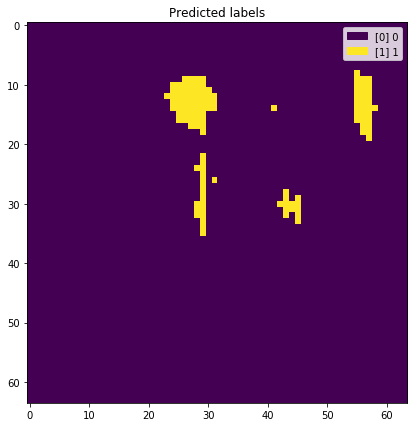

In [11]:
unet.predict(X_test, Y_labels=Y_test)

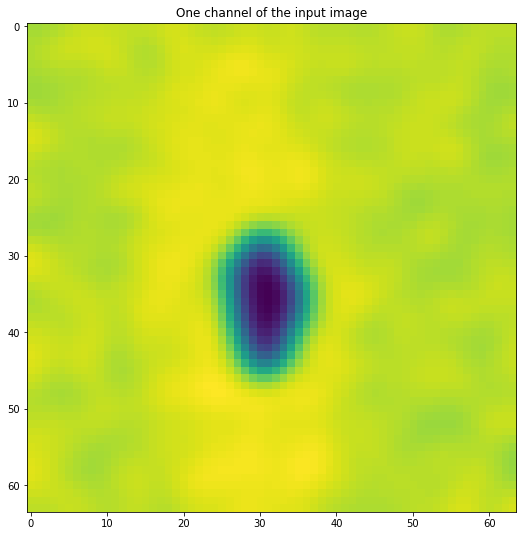

In [154]:
x = X_test[0, :, :, 7]

plt.figure(figsize=(9,9))
img = plt.imshow(x)
plt.title("One channel of the input image")
plt.show()

In [78]:
# x = X_test[0, :, :, 7]

# plt.figure(figsize=(9,9))
# img = plt.imshow(x)
# mypackage.Dataset._Dataset__add_legend_to_image(x, img)
# plt.title("One channel of the input image")
# plt.show()

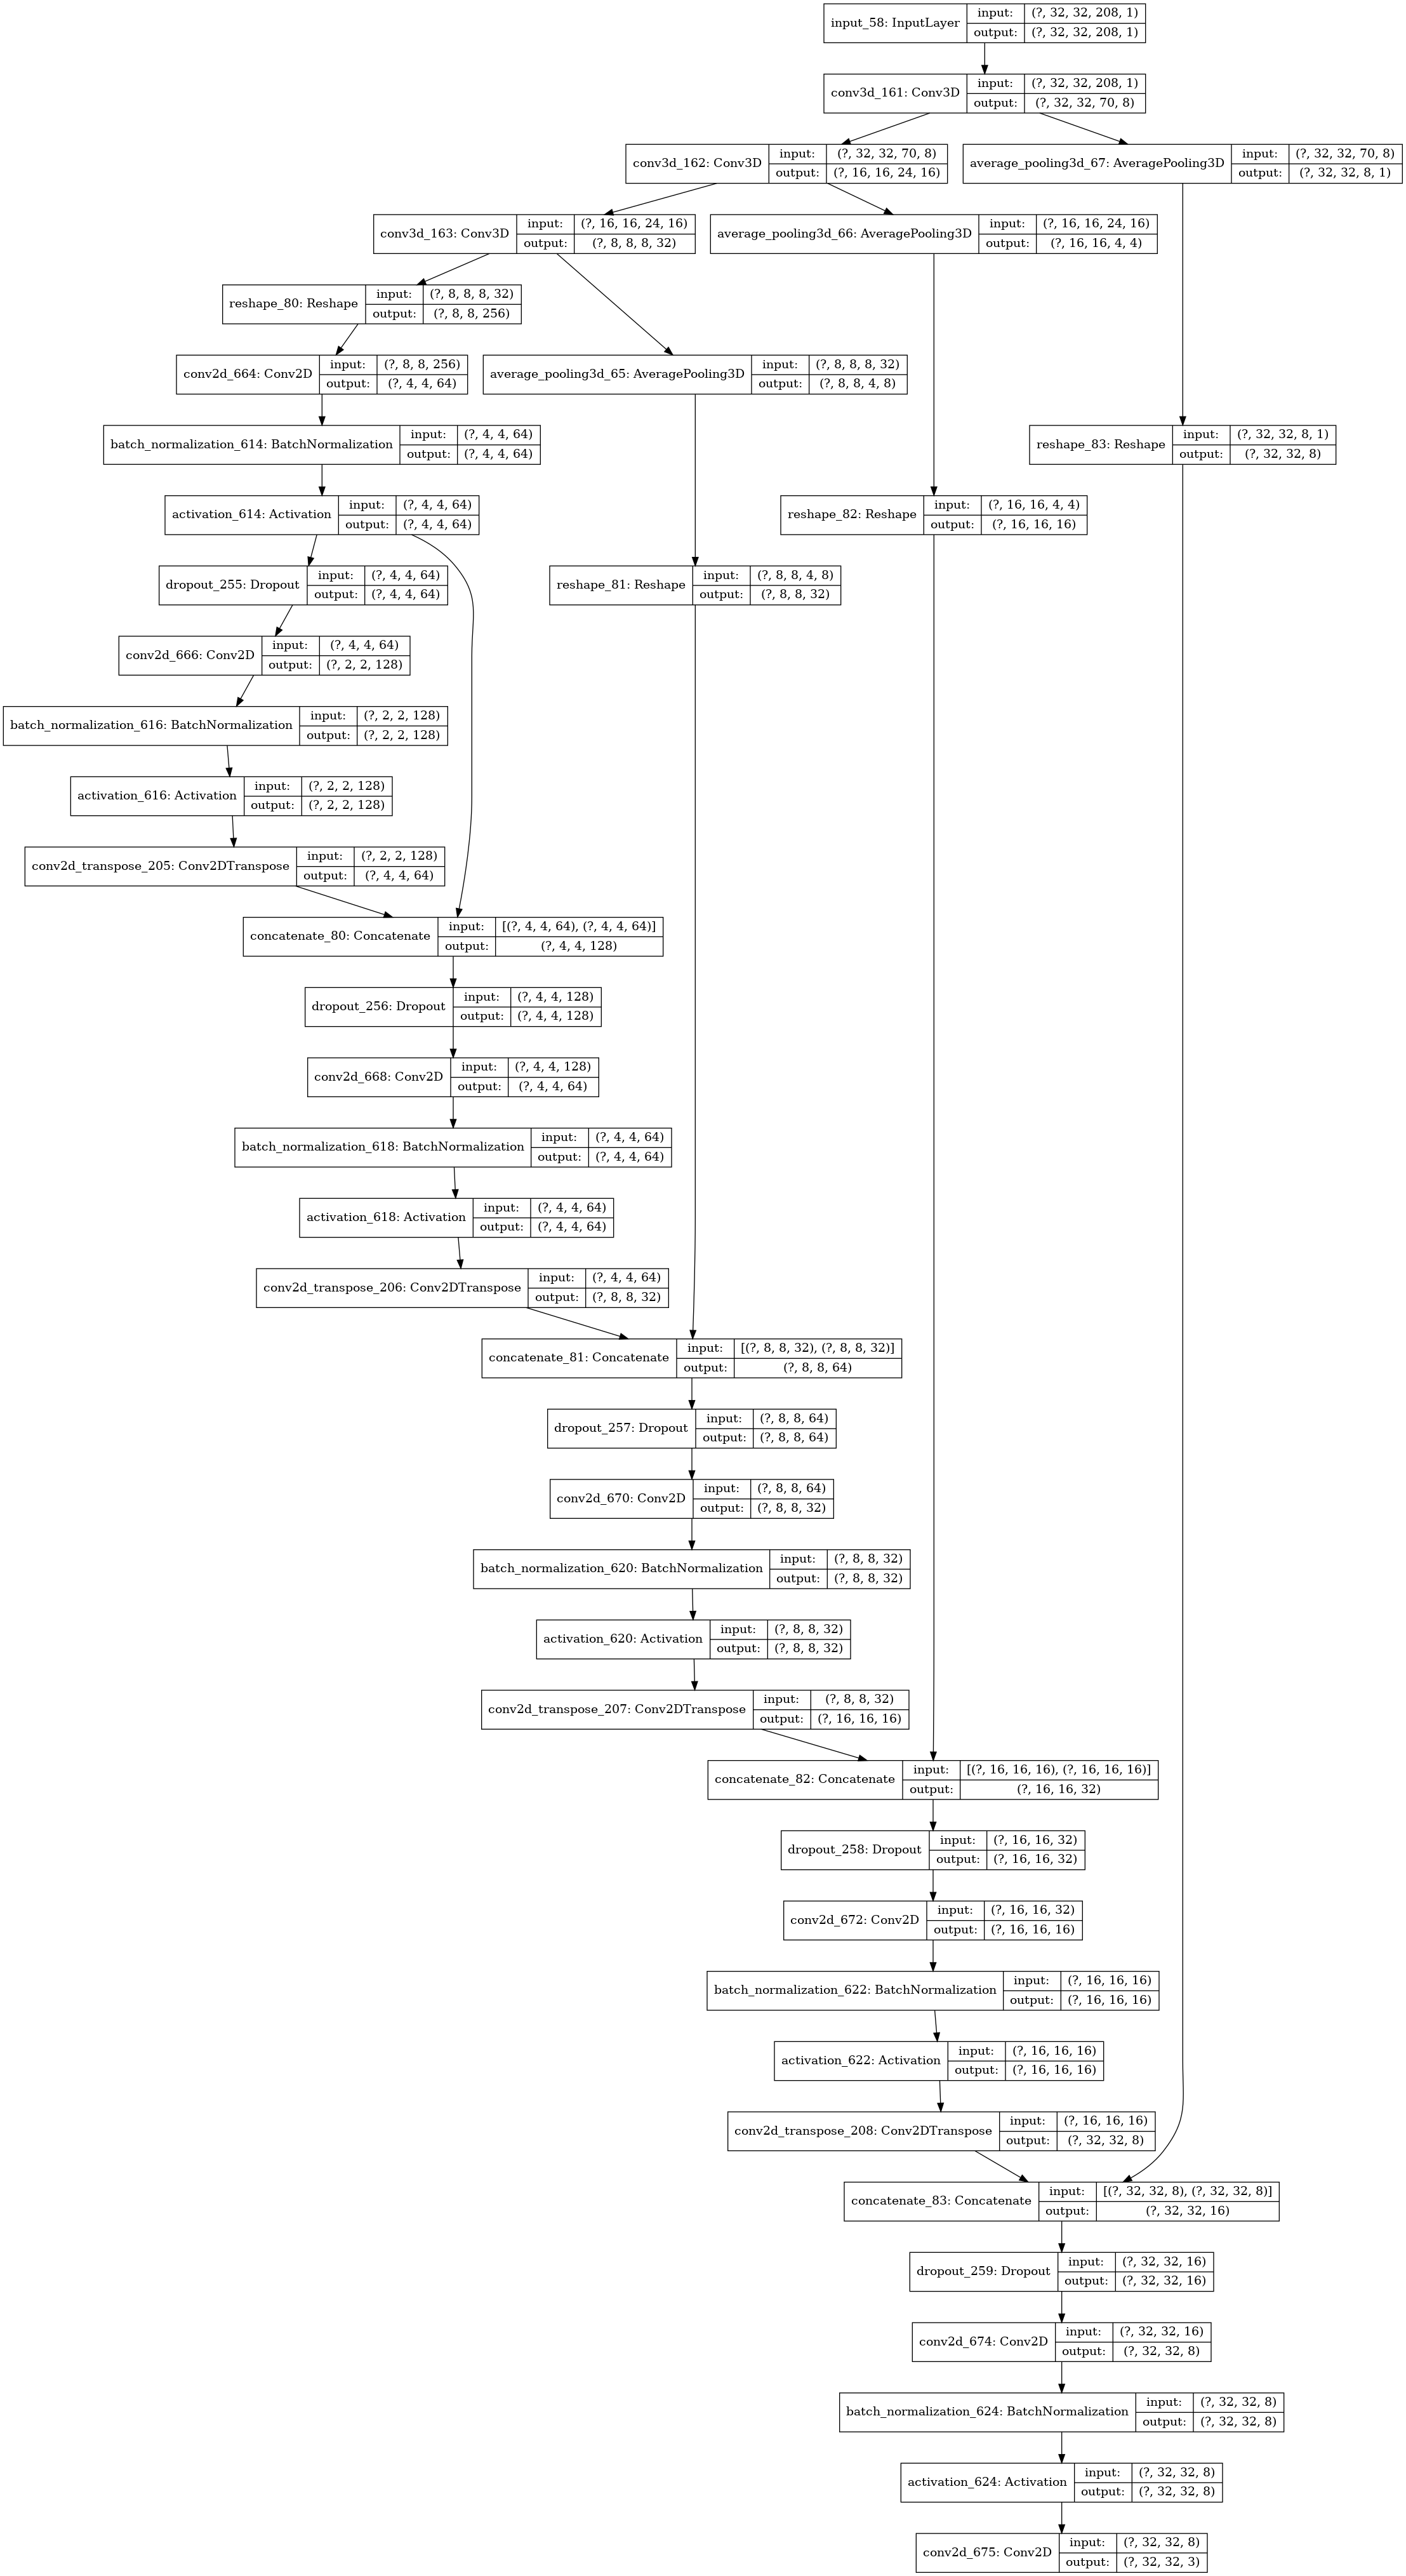

In [106]:
import tensorflow as tf

tf.keras.utils.plot_model(unet.model, show_shapes=True)